In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

from fastai.imports import *
from fastai.structured import *

import pandas as pd
from pandas_summary import DataFrameSummary
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn import metrics

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


from IPython.display import display

from imblearn.over_sampling import SMOTE


/Users/owner/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/owner/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [1]:
PATH = ".../train.csv"

**GINI calculations**


In [3]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]

In [4]:
data_raw= pd.read_csv(f'{PATH}', low_memory=False)

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [20]:
display_all(data_raw.tail())

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [7]:
# Describe the data set
display_all(data_raw.describe(include='all').transpose())

,count,mean,std,min,25%,50%,75%,max
id,595212.0,743803.558435,429367.820429,7.000000,371991.500000,743547.500000,1.115549e+06,1.488027e+06
target,595212.0,0.036448,0.187401,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000e+00,7.000000e+00
ps_ind_02_cat,595212.0,1.358943,0.664594,-1.000000,1.000000,1.000000,2.000000e+00,4.000000e+00
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000e+00,1.100000e+01
ps_ind_04_cat,595212.0,0.416794,0.493311,-1.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
ps_ind_05_cat,595212.0,0.405188,1.350642,-1.000000,0.000000,0.000000,0.000000e+00,6.000000e+00
ps_ind_06_bin,595212.0,0.393742,0.488579,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
ps_ind_07_bin,595212.0,0.257033,0.436998,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
ps_ind_08_bin,595212.0,0.163921,0.370205,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00


**Important observations:**
- Target variable (*target*) has its mean 3.65% meaning that only 3.65% of data is classified as the target. Hence, the dataset is unbalanced

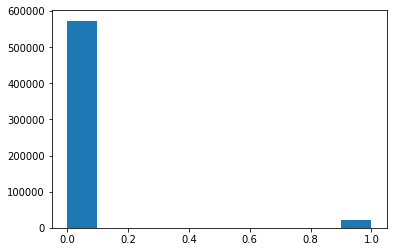

Percentage of claims filed : 3.64475178592 %


In [8]:
# Distribution of target variable
import matplotlib.pyplot as plt
plt.hist(data_raw['target'])
plt.show()

print('Percentage of claims filed :' , str(np.sum(data_raw['target'])/data_raw.shape[0]*100), '%')

But before jumping into balancing the data let's **look at the NA's, which in this dataset are denoted as -1**.

In [9]:
nas = np.sum(data_raw == -1)/len(data_raw) *100
print("The percentage of missing values is")
print (nas[nas>0].sort_values(ascending = False))

The percentage of missing values is
ps_car_03_cat    69.089837
ps_car_05_cat    44.782531
ps_reg_03        18.106490
ps_car_14         7.160474
ps_car_07_cat     1.930237
ps_ind_05_cat     0.975955
ps_car_09_cat     0.095596
ps_ind_02_cat     0.036290
ps_car_01_cat     0.017977
ps_ind_04_cat     0.013945
ps_car_11         0.000840
ps_car_02_cat     0.000840
ps_car_12         0.000168
dtype: float64


Now, for categorical variables we will create dummy variables (aka **one-hot encoding**)

In [31]:
# make a copy of the initial dataset
data_clean = data_raw.copy()
#data_clean.columns
cat_cols = [c for c in data_clean.columns if c.endswith('cat')]
for column in cat_cols:
    temp=pd.get_dummies(data_clean[column], prefix=column, prefix_sep='_')
    data_clean=pd.concat([data_clean,temp],axis=1)
    data_clean=data_clean.drop([column],axis=1)

print('data_clean shape is:',data_clean.shape)

data_clean shape is: (595212, 229)


In [33]:
# Impute missing values with medians

num_cols = ['ps_reg_03','ps_car_14', 'ps_car_11', 'ps_car_12' ]

for n in num_cols:
    dummy_name = str(n) + 'NA'
    data_clean[dummy_name] = (data_clean[n]==-1).astype(int)
    med = data_clean[data_clean[n]!=-1][n].median()
    data_clean.loc[data_clean[n]==-1,n] = med
    

    

In [16]:
#Make transformation to ps_car_13, as suggested here: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41489
data_clean['ps_car_13_trans'] = round(data_clean['ps_car_13']* data_clean['ps_car_13']* 90000,2)

In [34]:
# export to feather
data_clean.to_feather('/tmp/data_clean')
print('export complete')

export complete


In [77]:
data_clean = pd.read_feather('/tmp/data_clean')


**Undersampling**:
Let's take 25% of abundant data (target = 0) and stack together with the rare data (target = 1)

In [86]:
sub_df_0= data_clean[(data_clean['target']==0)]
sub_df_1= data_clean[(data_clean['target']==1)]
sub_df_1.shape

(21694, 233)

In [87]:
sub_df = sub_df_0.sample(frac = 0.25, random_state = 42)
data_sub = pd.concat([sub_df_1,sub_df])

## XGBoost model


In [88]:
# First split the data into training and validation (test) sets
training_features, test_features, \
training_target, test_target, = train_test_split(data_sub.drop(['id','target'], axis=1),
                                               data_sub['target'],
                                               test_size = .2,
                                               random_state=12)

# Now further split the training test into training and validation to 
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .2,
                                                  random_state=12)

We first run an XGB trainng model with some baseline parameters and then proceed to tuning the key parameters via a series of loops. 

To grasp an idea of what parameters to tune and in what order, look here:
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://www.slideshare.net/odsc/owen-zhangopen-sourcetoolsanddscompetitions1?next_slideshow=1

In [89]:
xgb_params = {'eta': 0.02, 
              'max_depth': 6, 
              'subsample': 1.0, 
              'colsample_bytree': 0.3,
              'min_child_weight': 1,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 99, 
              'silent': True}
#xgb.DMatrix(x_train[predictors].values, label=y_train.values)
d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_val,y_val)
d_test = xgb.DMatrix(test_features)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=100, early_stopping_rounds=200)
print(model.best_score, model.best_iteration, model.best_ntree_limit)

[0]	train-gini:0.196601	valid-gini:0.19429
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[100]	train-gini:0.321987	valid-gini:0.278464
[200]	train-gini:0.359511	valid-gini:0.285658
[300]	train-gini:0.392516	valid-gini:0.289204
[400]	train-gini:0.419991	valid-gini:0.289849
[500]	train-gini:0.443408	valid-gini:0.291014
[600]	train-gini:0.458003	valid-gini:0.290918
[700]	train-gini:0.473734	valid-gini:0.290754
[800]	train-gini:0.487845	valid-gini:0.290586
Stopping. Best iteration:
[648]	train-gini:0.465592	valid-gini:0.291336

0.291336 648 649


In [44]:
results = {'best_score':[],'best_iter':[],'best_ntree_limit':[]}


{'best_iter': [], 'best_ntree_limit': [], 'best_score': [1]}

train-gini:0.465592	valid-gini:0.291336
Best_ntree_limit = 649

Now, let's tune the **learning rate (eta)**

In [91]:
results = {'eta':[],'best_score':[],'best_ntree_limit':[]}
for e in [0.01, 0.02, 0.03,0.05,0.1,0.2]:
    xgb_params = {'eta': e, 
                  'max_depth': 6, 
                  'subsample': 1.0, 
                  'colsample_bytree': 0.3,
                  'min_child_weight': 1,
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 99, 
                  'silent': True}
    #xgb.DMatrix(x_train[predictors].values, label=y_train.values)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    m = xgb.train(xgb_params, d_train, 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=100, early_stopping_rounds=200)
    results['best_score'].append(m.best_score)
    results['best_ntree_limit'].append(m.best_ntree_limit)
    results['eta'].append(e)
    
print('eta:',results['eta'],'best_score:',results['best_score'],'best_ntree_limit:', results['best_ntree_limit'])

[0]	train-gini:0.196601	valid-gini:0.19429
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[100]	train-gini:0.306974	valid-gini:0.276946
[200]	train-gini:0.324915	valid-gini:0.279907
[300]	train-gini:0.341885	valid-gini:0.284432
[400]	train-gini:0.360752	valid-gini:0.286026
[500]	train-gini:0.379185	valid-gini:0.2878
[600]	train-gini:0.394244	valid-gini:0.288596
[700]	train-gini:0.408409	valid-gini:0.289171
[800]	train-gini:0.420627	valid-gini:0.289688
[900]	train-gini:0.433574	valid-gini:0.289878
[0]	train-gini:0.196601	valid-gini:0.19429
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[100]	train-gini:0.321987	valid-gini:0.278464
[200]	train-gini:0.359511	valid-gini:0.285658
[300]	train-gini:0.392516	valid-gini:0.289204
[400]	train-gini:0.419991	valid-gini:0.289849
[500]	train-gini:0.443408	

We see that **$\eta = 0.03$** gives better score of 0.293288 and at such learning rate **n_trees** = 341

We can now tune ```max_depth``` parameter

In [92]:
results = {'max_depth':[],'best_score':[],'best_ntree_limit':[]}
for md in range(3,9,1):
    xgb_params = {'eta': 0.03, 
                  'max_depth': md, 
                  'subsample': 1.0, 
                  'colsample_bytree': 0.3,
                  'min_child_weight': 1,
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 99, 
                  'silent': True}
    #xgb.DMatrix(x_train[predictors].values, label=y_train.values)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    m = xgb.train(xgb_params, d_train, 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=200)
    results['best_score'].append(m.best_score)
    results['best_ntree_limit'].append(m.best_ntree_limit)
    results['max_depth'].append(md)
    
print('max_depth:',results['max_depth'],'best_score:',results['best_score'],'best_ntree_limit:', results['best_ntree_limit'])

[0]	train-gini:0.152895	valid-gini:0.148037
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[50]	train-gini:0.254714	valid-gini:0.261111
[100]	train-gini:0.264271	valid-gini:0.268258
[150]	train-gini:0.275104	valid-gini:0.274721
[200]	train-gini:0.283029	valid-gini:0.278809
[250]	train-gini:0.290808	valid-gini:0.282106
[300]	train-gini:0.296478	valid-gini:0.284243
[350]	train-gini:0.301258	valid-gini:0.285575
[400]	train-gini:0.305827	valid-gini:0.286782
[450]	train-gini:0.310241	valid-gini:0.287885
[500]	train-gini:0.313672	valid-gini:0.288415
[550]	train-gini:0.31689	valid-gini:0.288889
[600]	train-gini:0.320219	valid-gini:0.289408
[650]	train-gini:0.322747	valid-gini:0.289832
[700]	train-gini:0.325932	valid-gini:0.290298
[750]	train-gini:0.328984	valid-gini:0.290569
[800]	train-gini:0.331656	valid-gini:0.29101
[850]	train-gini:0.334356	valid-gini:0.291343
[900]	train-gini:0.336958	valid

We can see that **```max_depth``` = 6** is the best choice, valid-gini:0.293288, n_trees_341
Now, let's tweak ```min_child_weight``` parameter


In [93]:
results = {'min_child_w':[],'best_score':[],'best_ntree_limit':[]}
for mcw in range(1,10,1):
    xgb_params = {'eta': 0.03, 
                  'max_depth': 6, 
                  'subsample': 1.0, 
                  'colsample_bytree': 0.3,
                  'min_child_weight': mcw,
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 99, 
                  'silent': True}
    #xgb.DMatrix(x_train[predictors].values, label=y_train.values)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    m = xgb.train(xgb_params, d_train, 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=200, early_stopping_rounds=200)
    results['best_score'].append(m.best_score)
    results['best_ntree_limit'].append(m.best_ntree_limit)
    results['min_child_w'].append(mcw)
    
print('min_child_w:',results['min_child_w'],'best_score:',results['best_score'],'best_ntree_limit:', results['best_ntree_limit'])

[0]	train-gini:0.196601	valid-gini:0.19429
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.390756	valid-gini:0.289544
[400]	train-gini:0.456514	valid-gini:0.292849
Stopping. Best iteration:
[340]	train-gini:0.44194	valid-gini:0.293288

[0]	train-gini:0.197209	valid-gini:0.19521
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.389033	valid-gini:0.290442
[400]	train-gini:0.455562	valid-gini:0.293512
Stopping. Best iteration:
[391]	train-gini:0.452666	valid-gini:0.293653

[0]	train-gini:0.197141	valid-gini:0.194548
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.38573	valid-gini:0.288662
[400]	train-gini:0.448931	valid-gini:0.28902
Stopping. Bes

So, ```min_child_weight``` = 2 is the best, valid-gini:0.293653, n_tree = 392
Finally, we can tweak ```colsample_bytree``` parameter


In [94]:
results = {'colsample_bytree':[],'best_score':[],'best_ntree_limit':[]}
for cst in [0.3,0.4,0.5]:
    xgb_params = {'eta': 0.03, 
                  'max_depth': 6, 
                  'subsample': 1.0, 
                  'colsample_bytree': cst,
                  'min_child_weight': 2,
                  'objective': 'binary:logistic', 
                  'seed': 99, 
                  'silent': True}
    #xgb.DMatrix(x_train[predictors].values, label=y_train.values)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    m = xgb.train(xgb_params, d_train, 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=200, early_stopping_rounds=200)
    results['best_score'].append(m.best_score)
    results['best_ntree_limit'].append(m.best_ntree_limit)
    results['colsample_bytree'].append(cst)
    
print('colsample_bytree:',results['colsample_bytree'],'best_score:',results['best_score'],'best_ntree_limit:', results['best_ntree_limit'])

[0]	train-gini:0.197209	valid-gini:0.19521
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.389033	valid-gini:0.290442
[400]	train-gini:0.455562	valid-gini:0.293512
Stopping. Best iteration:
[391]	train-gini:0.452666	valid-gini:0.293653

[0]	train-gini:0.204759	valid-gini:0.189515
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.393239	valid-gini:0.288466
[400]	train-gini:0.459999	valid-gini:0.289528
Stopping. Best iteration:
[248]	train-gini:0.413525	valid-gini:0.290517

[0]	train-gini:0.21643	valid-gini:0.209827
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.399235	valid-gini:0.289937
[400]	train-gini:0.463524	valid-gini:0.290695
Stopping. 

So, ```colsample_bytree``` = 0.3 is the best option with valid-gini = 0.293653 and n_tree = 392

In [95]:
training_features, test_features, \
training_target, test_target, = train_test_split(data_clean.drop(['id','target'], axis = 1),
                                               data_clean['target'],
                                               test_size = .2,
                                               random_state=12)

# Now further split the training test into training and validation to 
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .2,
                                                  random_state=12)

In [96]:
#Final model
xgb_params = {'eta': 0.03, 
                  'max_depth': 6, 
                  'subsample': 1.0, 
                  'colsample_bytree': 0.3,
                  'min_child_weight': 2,
                  'objective': 'binary:logistic', 
                  'seed': 99, 
                  'silent': True}
#xgb.DMatrix(x_train[predictors].values, label=y_train.values)
d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_val,y_val)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 392,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=200, early_stopping_rounds=200)

[0]	train-gini:0.190726	valid-gini:0.187986
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 200 rounds.
[200]	train-gini:0.359522	valid-gini:0.282232


In [97]:
model.best_score

0.287832

Now let's see what features are **important**

ps_car_13           1508
ps_reg_03           1303
ps_car_14            785
ps_ind_03            688
ps_reg_02            575
ps_ind_15            561
ps_ind_01            561
ps_calc_10           492
ps_calc_14           478
ps_reg_01            466
ps_car_15            451
ps_calc_03           435
ps_car_12            428
ps_calc_01           411
ps_calc_02           406
ps_calc_11           361
ps_calc_08           325
ps_calc_13           313
ps_calc_07           306
ps_calc_09           285
ps_calc_12           278
ps_calc_06           263
ps_calc_04           255
ps_calc_05           238
ps_ind_16_bin        194
ps_car_11            182
ps_ind_06_bin        163
ps_car_09_cat_1      160
ps_car_03_cat_1      158
ps_ind_05_cat_6      153
ps_reg_03NA          150
ps_ind_07_bin        150
ps_ind_05_cat_2      142
ps_ind_17_bin        142
ps_ind_04_cat_0      135
ps_car_07_cat_1      133
ps_car_01_cat_7      131
ps_car_03_cat_-1     128
ps_calc_17_bin       124
ps_car_09_cat_0      122


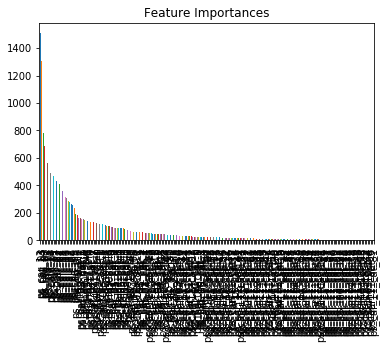

In [115]:
#Feature importance
feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
feat_imp[:60]


Looks like features with the score under 100 look equally unimportant. 
Thus, let's only keep those features that have a feature importance score >= 100.

In [117]:
to_keep = feat_imp[feat_imp>=100].index
df = data_clean[to_keep]
x_train = df
y_train = data_clean['target']

In [119]:
xgb_params = {'eta': 0.03, 
                  'max_depth': 6, 
                  'subsample': 1.0, 
                  'colsample_bytree': 0.3,
                  'min_child_weight': 2,
                  'objective': 'binary:logistic', 
                  'seed': 99, 
                  'silent': True}
#xgb.DMatrix(x_train[predictors].values, label=y_train.values)
d_train = xgb.DMatrix(x_train, y_train)
#d_valid = xgb.DMatrix(x_val,y_val)

#watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 392, feval=gini_xgb, maximize=True, verbose_eval=False)

In [120]:
test_clean = pd.read_feather('/tmp/test_clean')

In [123]:
x_test = test_clean[to_keep]
x_test.shape

(892816, 49)

In [2]:
#Prepare for submission
#make predictions

dtest = xgb.DMatrix(x_test)
xgb_pred = model.predict(dtest)

id_test = test_clean['id'].values
output = pd.DataFrame({'id': id_test, 'target': xgb_pred})
output.to_csv('.../submission.csv', index=False)



NameError: name 'xgb' is not defined

## Prepare Test Set

In [100]:
#Download and transform test set
test = pd.read_csv('.../test.csv', low_memory=False)


In [101]:
test.head(5)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [102]:
nas = np.sum(test == -1)/len(test) *100
print("The percentage of missing values is")
print (nas[nas>0].sort_values(ascending = False))

The percentage of missing values is
ps_car_03_cat    69.097216
ps_car_05_cat    44.842274
ps_reg_03        18.109442
ps_car_14         7.146489
ps_car_07_cat     1.941161
ps_ind_05_cat     0.975565
ps_car_09_cat     0.098229
ps_ind_02_cat     0.034386
ps_car_01_cat     0.017921
ps_ind_04_cat     0.016241
ps_car_02_cat     0.000560
ps_car_11         0.000112
dtype: float64


In [109]:
#Transformations
test_clean = test.copy()

cat_cols = [c for c in test_clean.columns if c.endswith('cat')]

# Creating dummies for missing values in categorical features
for column in cat_cols:
    temp=pd.get_dummies(test_clean[column], prefix=column, prefix_sep='_')
    test_clean=pd.concat([test_clean,temp],axis=1)
    test_clean=test_clean.drop([column],axis=1)

print('test_clean shape is:',test_clean.shape)

    
# Impute missing values with medians

num_cols = ['ps_reg_03','ps_car_14', 'ps_car_11']

for n in num_cols:
    dummy_name = str(n) + 'NA'
    test_clean[dummy_name] = (test_clean[n]==-1).astype(int)
    med = test_clean[test_clean[n]!=-1][n].median()
    test_clean.loc[test_clean[n]==-1,n] = med
    print(n,np.sum(data_clean[n] == -1)/len(data_clean) *100)


test_clean shape is: (892816, 228)
ps_reg_03 0.0
ps_car_14 0.0
ps_car_11 0.0


In [ ]:
# Saving test_clean to feather
test_clean.to_feather('/tmp/test_clean')
print('export complete')